# Air temperature Karlskrona
## Import necessary libraries and read the csv file

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import shapiro, anderson, kstest
import math
from statistics import mean
df = pd.read_csv("SMHI_Data.csv")
df

,Datum,Tid (UTC),Lufttemperatur
0,2010-03-01,00:00:00,2.0
1,2010-03-01,01:00:00,NaN
2,2010-03-01,02:00:00,2.2
3,2010-03-01,03:00:00,1.7
4,2010-03-01,04:00:00,1.7
...,...,...,...
113976,2023-01-01,02:00:00,6.2
113977,2023-01-01,03:00:00,6.5
113978,2023-01-01,04:00:00,7.7
113979,2023-01-01,05:00:00,8.7


## Data cleaning process (Q1)
To clean the data it hade to undergo the following steps: 

1. Check for and handle duplicates by removing duplicates except the first one
2. handle nan by taking the average of the two closest not NaN values
3. handle outliers by applying moving trimmed mean to each point in the dataset.

We do it in this order since duplicates would mess with the solution for NaN values and NaN values would mess with our solution for handling outliers.

The rest of this question will be answered down below where implement these solutions

### Duplicate data (Q1)  
Droping the 2093 duplicates with same date and time and keeping the first values.

In [129]:
n_old = len(df)
df.drop_duplicates(subset=['Datum', 'Tid (UTC)'], keep='first', inplace=True)
df = df.reset_index()
n_new = len(df)
print(f'Duplicates: {n_old - n_new}, Precentual: {(n_old - n_new)/n_old}')

Duplicates: 2093, Precentual: 0.018362709574402752


### Missing values (Q2)
Approximately 6% of the air temperature values are missing which is quite a lot in our opinion but not so many that it is impossible to clean the data and draw meaningful conclusions

In [130]:
null_values = df["Lufttemperatur"].isnull().sum()
df_length = len(df)

print(f"Missing values: {null_values}, Total values: {df_length}, Percentage missing: {(null_values / df_length) * 100}%")

Missing values: 6713, Total values: 111888, Percentage missing: 5.99974974974975%


### Replacing missing values (Q3)
Replace NAN values with the average of the two not NAN neighbouring values with equal distance to the subject value. We found this to be the most accurate way of getting suitable values for the data, since there usually isn't a big difference between the temperature at a specific time and the temperature one hour before or later to that time. Since the datapoints used for the average is at the same distance from the subject, we get an average value that is more accurate than if we would just pick the two closest not NAN values.

In [131]:
df["Cleaned"] = 0.0

def find_value(df, index):
    j = 0
    backward = df.at[index - j, "Lufttemperatur"]
    forward = df.at[index + j, "Lufttemperatur"]
    while math.isnan(backward) or math.isnan(forward):
        backward = df.at[index - j, "Lufttemperatur"]
        forward = df.at[index + j, "Lufttemperatur"]
        j+=1
    c = (backward+forward)/2
    
    return c

        
for index, row in df.iterrows():
    if index == len(df) - 1:
        df.at[index, "Cleaned"] = df.at[index-1, "Lufttemperatur"]
    else:
        df.at[index, "Cleaned"] = find_value(df, index)

df

,index,Datum,Tid (UTC),Lufttemperatur,Cleaned
0,0,2010-03-01,00:00:00,2.0,2.0
1,1,2010-03-01,01:00:00,NaN,2.1
2,2,2010-03-01,02:00:00,2.2,2.2
3,3,2010-03-01,03:00:00,1.7,1.7
4,4,2010-03-01,04:00:00,1.7,1.7
...,...,...,...,...,...
111883,113976,2023-01-01,02:00:00,6.2,6.2
111884,113977,2023-01-01,03:00:00,6.5,6.5
111885,113978,2023-01-01,04:00:00,7.7,7.7
111886,113979,2023-01-01,05:00:00,8.7,8.7


### Outliers (Q1)
Using the moving trimmed mean to replace outliers and get more reasonable data with a reduced amount of outliers. Moving trimmed mean is a more robust method compared to moving mean since it can handle adjacent outliers. This also works well since, as we stated before, the temperature for a specific hour doesn't deviate that much from previous or following hours. 

In [132]:
df["Trimmed"] = 0.0

def find_value(df, index):
    neighbors = [df.at[index, "Cleaned"]]
    for i in range(1, 6):
        try:
            backward = df.at[index - i, "Cleaned"]
            forward = df.at[index + i, "Cleaned"]
            neighbors.append(backward)
            neighbors.append(forward)
        except:
            pass
    return st.trim_mean(neighbors, 0.3)


for index, row in df.iterrows():
    df.at[index, "Trimmed"] = find_value(df, index)

df

,index,Datum,Tid (UTC),Lufttemperatur,Cleaned,Trimmed
0,0,2010-03-01,00:00:00,2.0,2.0,2.000000
1,1,2010-03-01,01:00:00,NaN,2.1,2.100000
2,2,2010-03-01,02:00:00,2.2,2.2,1.933333
3,3,2010-03-01,03:00:00,1.7,1.7,1.800000
4,4,2010-03-01,04:00:00,1.7,1.7,1.640000
...,...,...,...,...,...,...
111883,113976,2023-01-01,02:00:00,6.2,6.2,6.660000
111884,113977,2023-01-01,03:00:00,6.5,6.5,6.966667
111885,113978,2023-01-01,04:00:00,7.7,7.7,7.633333
111886,113979,2023-01-01,05:00:00,8.7,8.7,8.366667


We plot a month from the cleaned and trimmed values respectively to see how well it worked

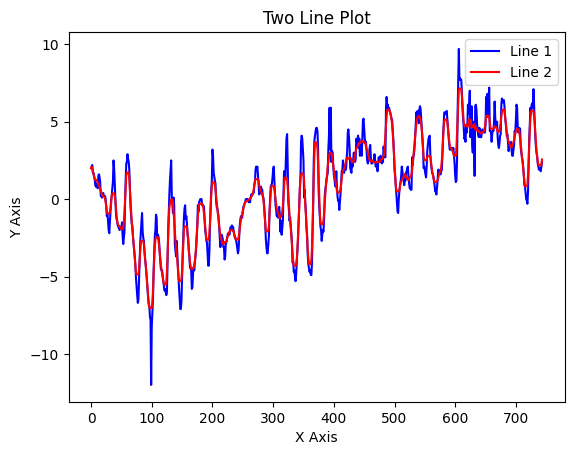

In [133]:
x = range(744)
y1 = df.Cleaned[0:744]
y2 = df.Trimmed[0:744]
plt.plot(x, y1, label='Line 1', color = "blue")
plt.plot(x, y2, label='Line 2', color="red")

plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Two Line Plot')

plt.show()

As we can see it worked really well with dealing with outliers (clearly demonstrated at point 100 on the x-axis)

## Statistics (Q4)
Getting some statistical values from both the cleaned and trimmed column in the dataset

In [134]:
# Minimum and maximum
minimum = df[["Cleaned", "Trimmed"]].min()
maximum = df[["Cleaned", "Trimmed"]].max()

print(f'minimum: \n{minimum}, \n\nMaximum: \n{maximum}')

minimum: 
Cleaned   -19.20
Trimmed   -14.04
dtype: float64, 

Maximum: 
Cleaned    39.60
Trimmed    31.87
dtype: float64


In [135]:
# Mean
mean = df[["Cleaned", "Trimmed"]].mean()

print(f'\nMean: \n{mean}')


Mean: 
Cleaned    9.433632
Trimmed    9.409913
dtype: float64


In [136]:
# Quartiles
q1 = df[["Cleaned", "Trimmed"]].quantile(0.25)
q2 = df[["Cleaned", "Trimmed"]].quantile(0.5)
q3 = df[["Cleaned", "Trimmed"]].quantile(0.75)

print(f'\nQ1: \n{q1}, \n\nQ2: \n{q2}, \n\nQ3: \n{q3}')


Q1: 
Cleaned    4.10
Trimmed    4.12
Name: 0.25, dtype: float64, 

Q2: 
Cleaned    9.10
Trimmed    9.08
Name: 0.5, dtype: float64, 

Q3: 
Cleaned    15.20
Trimmed    15.22
Name: 0.75, dtype: float64


In [137]:
# Standard deviation
standard = df[["Cleaned", "Trimmed"]].std()

print(f'\nStandard deviation: \n{standard}')


Standard deviation: 
Cleaned    6.997501
Trimmed    6.889050
dtype: float64


In [162]:
#Confidence interval
sem = st.sem(df[["Cleaned", "Trimmed"]])
ci = st.t.interval(0.95, len(df[["Cleaned", "Trimmed"]]) - 1, loc=mean, scale=sem)
con_int = {"Cleaned": (ci[0][0], ci[1][0]), "Trimmed": (ci[0][1], ci[1][1])}

print(f'confidence intervals:\nCleaned: {con_int["Cleaned"]}, \nTrimmed: {con_int["Trimmed"]}')

confidence intervals:
Cleaned: (9.392630390736405, 9.47463419527818), 
Trimmed: (9.36954669663983, 9.450279558186423)


## Plotting the data (Q5)

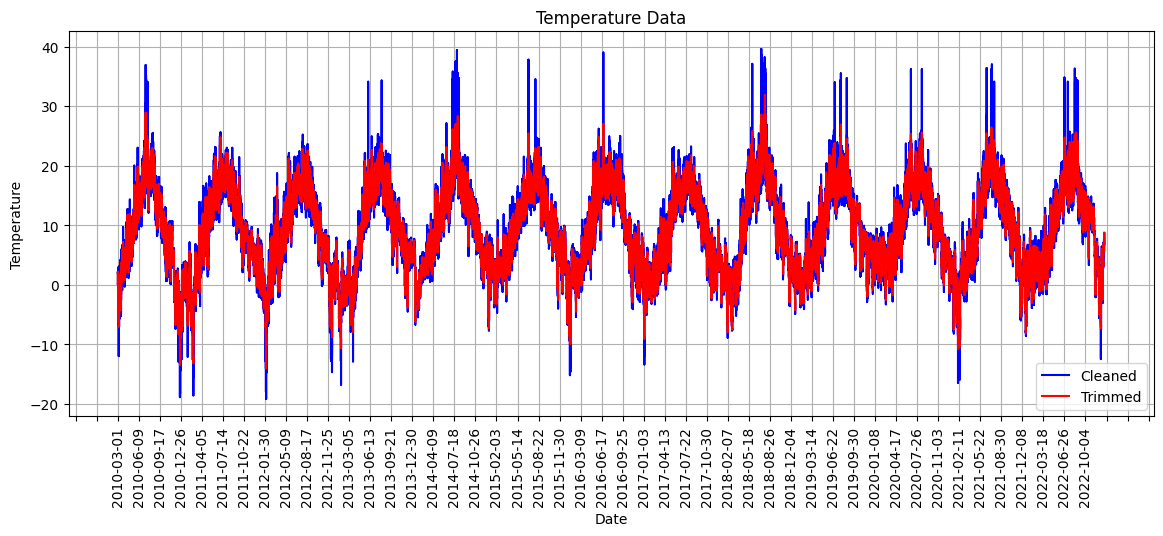

In [139]:
x = df.Datum
y1 = df.Cleaned
y2 = df.Trimmed

fig, ax = plt.subplots(figsize=(14, 5))

ax.plot(x, y1, label='Cleaned', color = "blue")
ax.plot(x, y2, label='Trimmed', color="red")

ax.xaxis.set_major_locator(plt.MaxNLocator(52))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Data')
ax.grid()
plt.legend()

plt.xticks(rotation=90)

plt.show()


## Coldest months (Q6)

In [140]:
months_string = ["Januari", "February", "Mars", "April", "May", "June", "July", "August", "September", "Oktober", "November", "December"]
months = []
for year in range(2010, 2024):
    for month in range(1, 13):
        if month < 10:
            month_df = df[df.Datum < f"{year}-0{month + 1}"]
            month_df = month_df[month_df.Datum > f"{year}-0{month}"]
        else:
            month_df = df[df.Datum < f"{year}-{month + 1}"]
            if month == 10:
                month_df = month_df[month_df.Datum > f"{year}-0{month}"]
            else:
                month_df = month_df[month_df.Datum > f"{year}-0{month}"]
        if len(month_df) > 0:
            month_df.reset_index(inplace=True)
            months.append(month_df)

temp_dict = {}
for month in months:
    temp_dict[month["Datum"][0][0:7]] =  month["Trimmed"].mean()  

sorted_temp_dict = dict(sorted(temp_dict.items(), key=lambda item: item[1]))

print("The 10 coldest months are:")

for i in range(10):
    print(f'{list(sorted_temp_dict.keys())[i][:4]}/{months_string[int(list(sorted_temp_dict.keys())[i][-1])-1]}: {list(sorted_temp_dict.values())[i]}')

The 10 coldest months are:
2016/Januari: -0.9008344549125169
2013/Mars: -0.8446505376344086
2013/Januari: -0.6412500000000002
2011/Januari: -0.44310483870967754
2018/Mars: -0.009528301886792635
2017/Januari: 0.715255376344086
2021/Januari: 0.8259834938101787
2019/Januari: 1.0954716981132075
2014/Januari: 1.263279569892473
2012/Januari: 1.5784543010752687


## Finding the distrubution (Q7)
We start by plotting a histogram of the data to see if the distrubution is clearly visible

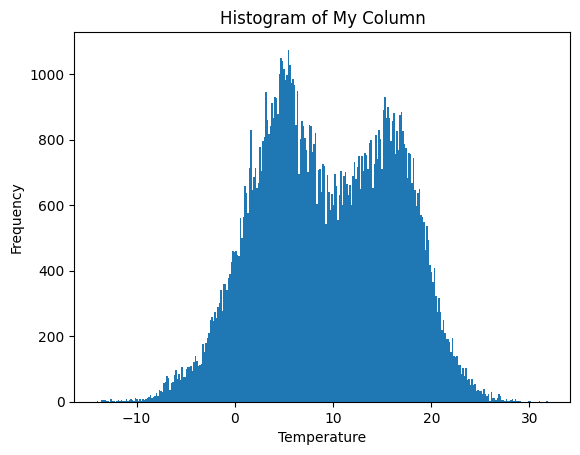

In [158]:
plt.hist(df['Trimmed'], bins=300)

# Add labels and a title to the plot
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

# Display the plot
plt.show()

We can see that the data is bimodal (has two peaks). We try to split the two peaks by plotting histograms of different halfs of the year

We seperate the data into 2 datasets. One with all the data from december 1st to the 15th of may and one with all the data from the 16th of may to the 31st of november

In [142]:
def transform_int(i):
    if i < 10:
        return "0"+str(i)
    else: return str(i)

In [143]:
winter_df = pd.DataFrame()
summer_df = pd.DataFrame()

for year in range(2010, 2024):
    month_df = df[df.Datum >= f"{year - 1}-12-01"]
    month_df = month_df[month_df.Datum <= f"{year}-05-15"]
    winter_df = winter_df.append(month_df)

    month_df = df[df.Datum <= f"{year}-11-31"]
    month_df = month_df[month_df.Datum >= f"{year}-05-16"]
    summer_df = summer_df.append(month_df)

We make a histogram and a Q-Q plot of the data in the "winter set" (12/01 - 05/15)

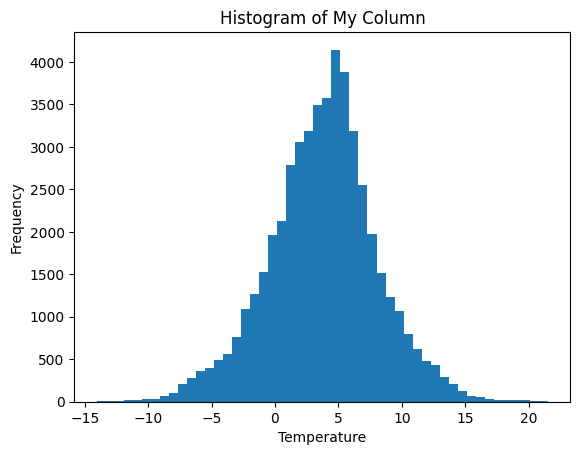

In [144]:
plt.hist(winter_df['Trimmed'], bins=50)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

plt.show()

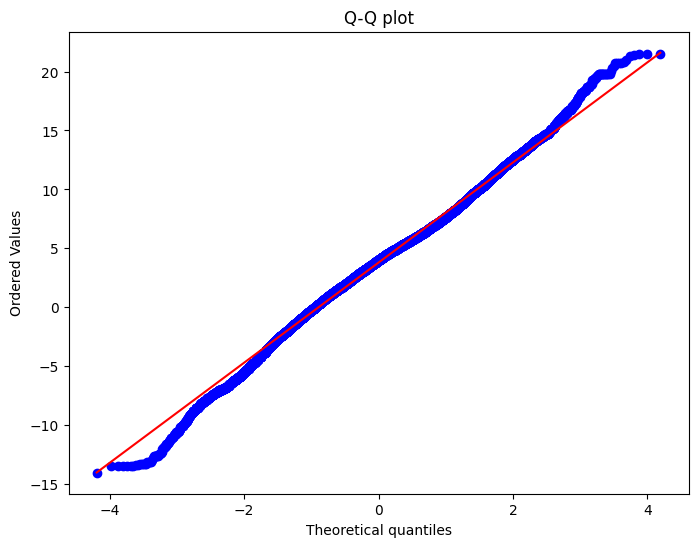

In [145]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(winter_df["Trimmed"], dist="norm", plot=ax)
ax.set_title('Q-Q plot')
plt.show()

Here we can see that the data appears to be normally distributed since the dots on the Q-Q plot follows the red line with only a few exceptions and the histogram is bell-shaped. 


We now do the same thing with the "summer set" (05/16-11/31)

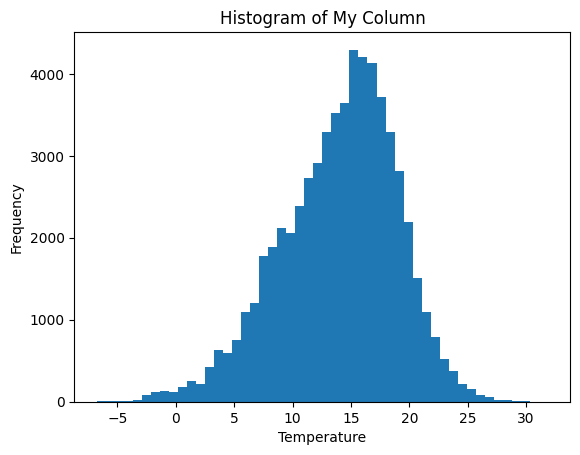

In [146]:
plt.hist(summer_df['Trimmed'], bins=50)

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of My Column')

plt.show()

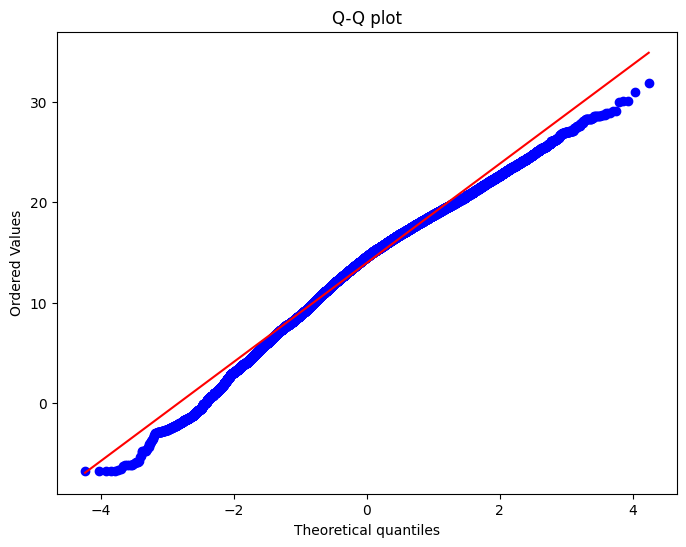

In [147]:
fig, ax = plt.subplots(figsize=(8, 6))
st.probplot(summer_df["Trimmed"], dist="norm", plot=ax)
ax.set_title('Q-Q plot')
plt.show()

We appear to get the same result for the summer set as for the winter set

Following the graphs above we came to the conclusion that the distribution is a bimodal distribution. The peaks seams to represent the summer and winter months when it is warmer or colder for a longer period of time. If we seperate the "summer half" and the "winter half" of the year we get two normally distrubuted datasets.

### Extreme values (Q8)

In [148]:
Outliers_below = df[["Cleaned"]].quantile(0.001)
Outliers_above = df[["Cleaned"]].quantile(0.999)

print(f'Outliers below: \n{Outliers_below}')
print()
print(f'Outliers above: \n{Outliers_above}')

Outliers below: 
Cleaned   -10.7
Name: 0.001, dtype: float64

Outliers above: 
Cleaned    29.1113
Name: 0.999, dtype: float64


We consider values below -10.7 degrees and above 29.1 degrees to be outliers since less than 0.2% of all values are within any of these categories.

In [149]:
outliers = len(df[df.Cleaned > 29.1])
outliers += len(df[df.Cleaned < -10.7])

print(f'Total outliers before data cleaning: {outliers}')

outliers_after = len(df[df.Trimmed > 29.1])
outliers_after += len(df[df.Trimmed < -10.7])

print(f'Total outliers after data cleaning: {outliers_after}')

Total outliers before data cleaning: 221
Total outliers after data cleaning: 70


As we can see above there are 221 of these values in the dataset but after we apply moving average trimmed mean to the dataset, we get rid of about two thirds of all these values which we consider to be a big improvement

### Average daily mean (Q9)

First we extract the mean for each day in 2022:

In [163]:
df_2022 = df[df.Datum > '2021-12-31']
df_2022 = df_2022[df_2022.Datum < '2023-01-01']

dates = []
means = []
temp_temps = []


#Yes we know the group by function exists, we are just stupid and didn't think of it
for date, temp in zip(df_2022.Datum, df_2022.Trimmed):
    if date in dates:
        temp_temps.append(temp)
    else:
        if len(temp_temps) > 0:
            means.append(np.mean(temp_temps))
        temp_temps = [temp]
        dates.append(date)
means.append(np.mean(temp_temps))

Then we plot it:

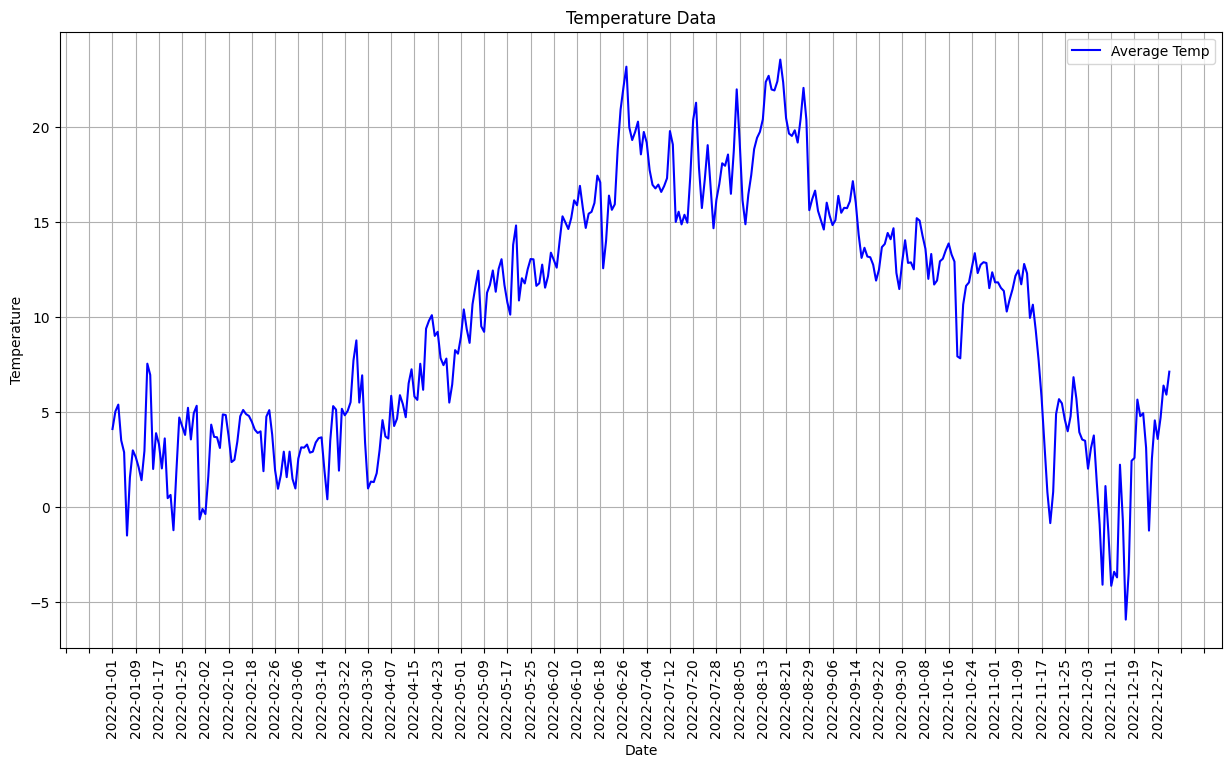

In [160]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(dates, means, label='Average Temp', color = "blue")

ax.xaxis.set_major_locator(plt.MaxNLocator(52))

ax.set_xlabel('Date')
ax.set_ylabel('Temperature')
ax.set_title('Temperature Data')
ax.grid()
plt.legend()

plt.xticks(rotation=90)

plt.show()

### Consecutive months (Q10)

In [161]:
def get_month(year, month):
    month_df = df[df.Datum < f"{year}-{transform_int(month + 1)}"]
    month_df = month_df[month_df.Datum > f"{year}-{transform_int(month)}"]
    return month_df

y1 = 2010
y2 = 2010
m1 = 2
m2 = 3


month_dict = {}
while y2 != 2023:
    x1 = 0
    x2 = 0

    month = get_month(y1, (m1%12)+1)
    month2 = get_month(y2, (m2%12)+1)
    x1 = month.Trimmed.mean()
    
    x2 = month2.Trimmed.mean()

    x3 = (x2 + x1)/2

    month_dict[str(y1) + "/" + transform_int((m1%12)+1) + " and " + str(y2) + "/" + transform_int((m2%12)+1)] = x3

    m1 += 1
    m2 += 1
    y1 = (m1//12) + 2010
    y2 = (m2//12) + 2010


sorted_temp_dict = dict(sorted(month_dict.items(), key=lambda item: item[1], reverse=True))

print("The 10 hottest consecutive months are:")
for i in range(10):
    print(f'{list(sorted_temp_dict.keys())[i]}: {list(sorted_temp_dict.values())[i]}')




The 10 hottest consecutive months are:
2018/07 and 2018/08: 20.662693646066852
2018/06 and 2018/07: 19.634804657282086
2021/06 and 2021/07: 19.456611282785076
2014/07 and 2014/08: 19.203291541055997
2010/07 and 2010/08: 18.747041875746717
2021/07 and 2021/08: 18.640001443295937
2022/07 and 2022/08: 18.47490576010375
2019/07 and 2019/08: 18.334723140313766
2013/07 and 2013/08: 18.244476299289854
2014/06 and 2014/07: 18.003001456547885
